# Preparation

In [1]:
#!git clone https://github.com/facebookresearch/detr

In [32]:
import os
import numpy as np 
import pandas as pd 
from datetime import datetime
import time
#import random
from tqdm.autonotebook import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

################# DETR FUCNTIONS FOR LOSS######################## 
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion, DETR
#################################################################

import matplotlib.pyplot as plt

#Glob
from glob import glob

#added
import json
import itertools
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from numpy.random import rand, randint, ranf, randn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, utils
import torchvision.transforms.functional as tf
from util.misc import (NestedTensor, nested_tensor_from_tensor_list,
                       accuracy, get_world_size, interpolate,
                       is_dist_avail_and_initialized)
%matplotlib inline

# Utils

* AverageMeter - class for averaging loss,metric,etc over epochs

In [33]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Configuration

Basic configuration for this model

# Preparing the Data

* For preparation of data I use code from Alex's awesome kernel [here](https://www.kaggle.com/shonenkov/training-efficientdet)
* The data can be split into any number of folds as you want , split is stratified based on number of boxes and source

In [60]:
PATH = '../laneDetection/data/train_set/'
annotations_list = ['label_data_0313.json', 'label_data_0531.json', 'label_data_0601.json']
gt_list = [[json.loads(line) for line in open(PATH+anno).readlines()] for anno in annotations_list]
gt_list = list(itertools.chain.from_iterable(gt_list))

#PATH = '../laneDetection/data/test_set/'
#annotations_list = ['test_label.json']
#gt_list_test = [[json.loads(line) for line in open(PATH+anno).readlines()] for anno in annotations_list]
#gt_list_test = list(itertools.chain.from_iterable(gt_list_test))
#gt_list = list(itertools.chain.from_iterable([gt_list, gt_list_test]))

In [61]:
train_list, val_list = train_test_split(gt_list, test_size=0.05, shuffle=True, random_state=0)

In [62]:
IMG_WIDTH = 1280
IMG_HEIGHT = 720

RESIZE_SCALE = 4
MODEL_SCALE = 8
MODEL_WIDTH = 1280//RESIZE_SCALE//MODEL_SCALE
MODEL_HEIGHT = 720//RESIZE_SCALE//MODEL_SCALE

In [63]:
def preprocess_image(img, training=False, fliplr=False, shear=0, scale=1, crop=(IMG_WIDTH,IMG_HEIGHT), off=(0,0)):
    
    if training:
        if fliplr:
            img = ImageOps.mirror(img)
        transformed = tf.affine(img, angle=0, translate=(0,0), scale=scale, shear=shear)
        off_x, off_y = off
        img_width, img_height = crop
        cropped = tf.crop(transformed, off_y, off_x, img_height, img_width)
    else:
        cropped = img
    resized = transforms.Resize((IMG_HEIGHT//RESIZE_SCALE,IMG_WIDTH//RESIZE_SCALE))(cropped)
    resized = transforms.ToTensor()(resized)
    
    return resized

def get_lane_points(gt, training=False, fliplr=False, shear=0, scale=1, crop=(IMG_WIDTH,IMG_HEIGHT), off=(0,0)):
    # ground truthの読み込み
    gt_lanes = gt['lanes']
    
    df = pd.DataFrame(gt_lanes, dtype=np.float).T
    df["x"] = gt['h_samples']
    df = df.set_index("x")
    df[df==-2] = np.NaN
    
    model_height = IMG_HEIGHT//RESIZE_SCALE//MODEL_SCALE
    model_width = IMG_WIDTH//RESIZE_SCALE//MODEL_SCALE
    
    # data augmentation
    if training:
        if fliplr:
            df = (IMG_WIDTH - 1) - df
        #transformed = tf.affine(img, angle=0, translate=(0,0), scale=scale, shear=shear)用の変換
        df.index = df.index*scale + IMG_HEIGHT*(1-scale)/2
        df = df*scale + IMG_WIDTH*(1-scale)/2
        off_y = np.array(df.index-IMG_HEIGHT/2).reshape((-1,1))
        df -= off_y*np.tan(shear/180*np.pi)
        #cropped = tf.crop(transformed, off_y, off_x, img_height, img_width)用の変換
        off_x, off_y = off
        img_width, img_height = crop
        df.index -= off_y
        df.index *= model_height/img_height
        df -= off_x
        df *= model_width/img_width
    else:
        img_width, img_height = IMG_WIDTH, IMG_HEIGHT
        df.index *= model_height/img_height
        df *= model_width/img_width
    
    # resize後の画像上の基準高さの行を追加
    df_nan = pd.DataFrame(index=np.arange(0.5,model_height),columns=[0,1,2,3,4,5,6,7,8,9])
    df = pd.concat([df, df_nan])
    # 重複行を削除
    df = df.groupby(level=0)  
    df = df.last()
    # データを内挿,区画線点が1点しかない場合、splineの外挿ができない。その場合は外挿はしない
    for i in range(10):
        try:
            df[i] = df[i].interpolate(method="slinear", limit_area="inside")
            df[i] = df[i].interpolate(limit_direction="forward",method="spline", order=1)
        except:
            pass
        
    # 画像から外れた場所を削除
    df[df<0] = np.NaN
    df[df>model_width] = np.NaN
    
    lane_points = df
    lane_points_scaled = lane_points[np.mod(lane_points.index-0.5,1)==0] # 等間隔のy座標に置けるlane位置のみを抽出
    
    return lane_points_scaled

def line_points_to_label(lane_points):
    arg = np.arange(MODEL_HEIGHT)
    labels, xListCoords, yBoundaries = [], [], []
    for i in range(10):
        if not all(np.isnan(lane_points[i].values)):
            isNotLine = np.isnan(lane_points[i].values)
            isLine = np.logical_not(isNotLine)
            labels.append(1 if all(isNotLine) else 0)
            xListCoords.append(lane_points[i].values)
            yBoundaries.append([0,1] if all(isNotLine) else [np.min(arg[isLine]), np.max(arg[isLine])+1])
            
    return np.array(labels), np.array(xListCoords)/MODEL_WIDTH, np.array(yBoundaries)/MODEL_HEIGHT

In [64]:
def get_img_path(gt):
    return PATH+gt['raw_file']

In [65]:
gt = train_list[0]
img_name = gt['raw_file']
img_name_path = get_img_path(gt)
img = Image.open(img_name_path)

#img, offset, scale = preprocess_image(img,True)
fliplr = rand()>.5
shear = (2*rand()-1)*60
scale = .8
crop_width = int((rand()*(1-scale+.2)+scale-.2)*IMG_WIDTH)
crop_height = int((rand()*(1-scale+.2)+scale-.2)*IMG_HEIGHT)
crop = (crop_width, crop_height)
off_x = rand()*(IMG_WIDTH-crop_width)
off_y = rand()*(IMG_HEIGHT-crop_height)
off = (off_x, off_y)
img = preprocess_image(img, True, fliplr, shear, scale, crop, off)
lane_coords = get_lane_points(gt, True, fliplr, shear, scale, crop, off)
labels, xListCoords, yBoundaries = line_points_to_label(lane_coords)
yCoords = lane_coords.index

In [66]:
def drawLine(img, labels, xListCoords, yBoundaries, yCoords):
    
    arg = np.arange(MODEL_HEIGHT)
    for label, xList, yBound in zip(labels, xListCoords, yBoundaries):
        if label!=1:
            laneExistUp = yBound[0]*MODEL_HEIGHT <= arg+.5
            laneExistDown = arg+.5<= yBound[1]*MODEL_HEIGHT
            laneExist = np.logical_and(laneExistUp,laneExistDown)
            plt.plot(xList[laneExist]*IMG_WIDTH/RESIZE_SCALE, 
                     yCoords[laneExist]/MODEL_HEIGHT*IMG_HEIGHT/RESIZE_SCALE, marker='.')
    
    img = np.array(img)
    img = np.rollaxis(img,0,3)
    plt.imshow(img)
    
    plt.xlim([0,IMG_WIDTH//RESIZE_SCALE])

def line2bbox(xListCoords, yBoundaries):
    """output: x0,y0,x1,y1"""
    bbox = np.zeros((xListCoords.shape[0],4))
    x0 = np.nanmin(xListCoords, axis=1)
    x1 = np.nanmax(xListCoords, axis=1)
    y0 = np.nanmin(yBoundaries, axis=1)
    y1 = np.nanmax(yBoundaries, axis=1)
    
    bbox[:,0] = (x0+x1)/2 #cx
    bbox[:,1] = (y0+y1)/2 #cy
    bbox[:,2] = x1-x0 #w
    bbox[:,3] = y1-y0 #h
    
    return bbox

def drawBbox(img, labels, bboxes):
    img = np.array(img)
    img = np.rollaxis(img,0,3)
    height, width, _ = img.shape
    
    bboxes_ = np.zeros_like(bboxes)
    bboxes_[:,0] = (bboxes[:,0]-.5*bboxes[:,2])*width
    bboxes_[:,2] = (bboxes[:,0]+.5*bboxes[:,2])*width
    bboxes_[:,1] = (bboxes[:,1]-.5*bboxes[:,3])*height
    bboxes_[:,3] = (bboxes[:,1]+.5*bboxes[:,3])*height
    
    plt.imshow(img)
    
    for label, (x0,y0,x1,y1) in zip(labels, bboxes_):
        if label!=1:
            plt.plot([x0,x1,x1,x0,x0],[y0,y0,y1,y1,y0])
    
    plt.xlim([0,IMG_WIDTH//RESIZE_SCALE])
    plt.ylim([IMG_HEIGHT//RESIZE_SCALE,0])

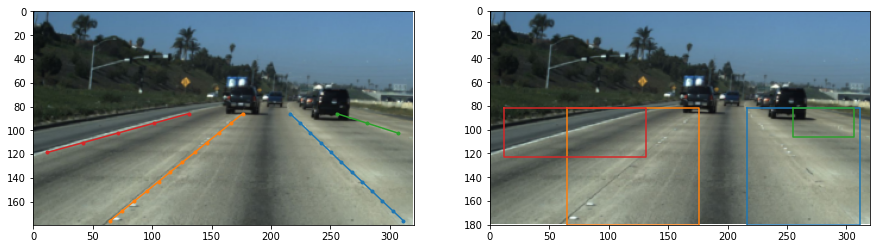

In [67]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
drawLine(img, labels, xListCoords, yBoundaries, yCoords)
plt.subplot(1,2,2)
bboxes = line2bbox(xListCoords, yBoundaries)
drawBbox(img, labels, bboxes)

# Creating Dataset

* I hope you have the video by now , DETR accepts data in coco format which is (x,y,w,h)(for those who do not know there are two formats coco and pascal(smin,ymin,xmax,ymax) which are widely used) . So now we need to prepare data in that format

In [68]:
class CarDataset(Dataset):
    """Car dataset."""

    def __init__(self, data_list, training=False):
        self.data_list = data_list
        self.root_dir = PATH
        self.training = training
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        # Get data for pytorch
        # preprocess is done in self.getitem, and return except for gt
        # because batch process cannot treat not-fixed length
        img, targets = self.getitem(idx)
        
        return img, targets
    
    def getitem(self, idx):
        gt = self.data_list[idx]
        img_name = gt['raw_file']
        img_path = self.root_dir + img_name
        img = Image.open(img_path)
        
        if self.training:
            fliplr = rand()>.5
            shear = (2*rand()-1)*60
            scale = .8
            crop_width = int((rand()*(1-scale+.2)+scale-.2)*IMG_WIDTH)
            crop_height = int((rand()*(1-scale+.2)+scale-.2)*IMG_HEIGHT)
            crop = (crop_width, crop_height)
            off_x = rand()*(IMG_WIDTH-crop_width)
            off_y = rand()*(IMG_HEIGHT-crop_height)
            off = (off_x, off_y)
            img = preprocess_image(img, True, fliplr, shear, scale, crop, off)
        else:
            img = preprocess_image(img)
        
        if self.training:
            lane_coords = get_lane_points(gt, True, fliplr, shear, scale, crop, off)
        else:
            lane_coords = get_lane_points(gt)
        isLines, xListCoords, yBoundaries = line_points_to_label(lane_coords)
        bboxes = line2bbox(xListCoords, yBoundaries)
        # img = np.rollaxis(img, 2, 0) # PILでimageを読み込むように変更したため不要
        
        target = {
            "labels" : torch.as_tensor(isLines),
            "xCoords" : torch.as_tensor(xListCoords),
            "yBounds" : torch.as_tensor(yBoundaries),
            "boxes" : torch.as_tensor(bboxes)
        }
        
        return img, target

In [69]:
train_dataset = CarDataset(train_list, training=True)
val_dataset = CarDataset(val_list, training=True)
val_dataset_noaug = CarDataset(val_list, training=False)

In [70]:
BATCH_SIZE = 16

def collate_fn(batch):
    return tuple(zip(*batch))

# Create data generators - they will produce batches
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=4)
val_loader_noaug = DataLoader(dataset=val_dataset_noaug, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn, num_workers=0)

# Model

* Initial DETR model is trained on coco dataset , which has 91 classes + 1 background class , hence we need to modify it to take our own number of classes
* Also DETR model takes in 100 queries ie ,it outputs total of 100 bboxes for every image , we can very well change that too

In [71]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries
        
        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features
        
        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=num_classes)
        self.model.yBound_embed = nn.Linear(in_features=self.in_features,out_features=2)
        self.model.xCoord_embed = nn.Linear(in_features=self.in_features,out_features=MODEL_HEIGHT)
        self.model.num_classes = num_classes
        self.model.num_queries = num_queries
        
        
        hidden_dim = self.model.transformer.d_model
        self.model.query_embed = nn.Embedding(num_queries, hidden_dim)
        
    def forward(self,images):
        ## from facebook/DETR
        if isinstance(images, (list, torch.Tensor)):
            images = nested_tensor_from_tensor_list(images)
        features, pos = self.model.backbone(images)

        src, mask = features[-1].decompose()
        assert mask is not None
        hs = self.model.transformer(self.model.input_proj(src), mask, self.model.query_embed.weight, pos[-1])[0]

        outputs_class = self.model.class_embed(hs)
        outputs_yBound = self.model.yBound_embed(hs)
        outputs_xCoord = self.model.xCoord_embed(hs)
        out = {'pred_logits': outputs_class[-1],
               'pred_yBounds': outputs_yBound[-1],
               'pred_xCoords': outputs_xCoord[-1]}
        return out

# Matcher and Bipartite Matching Loss

Now we make use of the unique loss that the model uses and for that we need to define the matcher. DETR calcuates three individual losses :
* Classification Loss for labels(its weight can be set by loss_ce)
* Bbox Loss (its weight can be set by loss_bbox)
* Loss for Background class

In [72]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = {'loss_ce': 1, 'loss_yBounds': 1 , 'loss_xCoords': 1}

losses = ['labels', 'yBounds', 'xCoords']

# Eval Function

In [73]:
class SetLaneCriterion(SetCriterion):
    
    def loss_labels(self, outputs, targets, indices, num_boxes, log=True):
        """Classification loss (NLL)
        targets dicts must contain the key "labels" containing a tensor of dim [nb_target_boxes]
        """
        assert 'pred_logits' in outputs
        src_logits = outputs['pred_logits']

        idx = self._get_src_permutation_idx(indices)
        target_classes_o = torch.cat([t["labels"][J] for t, (_, J) in zip(targets, indices)])
        target_classes = torch.full(src_logits.shape[:2], self.num_classes,
                                    dtype=torch.int64, device=src_logits.device)
        target_classes[idx] = target_classes_o

        loss_ce = F.cross_entropy(src_logits.transpose(1, 2), target_classes, self.empty_weight)
        losses = {'loss_ce': loss_ce}

        if log:
            # TODO this should probably be a separate loss, not hacked in this one here
            losses['class_error'] = 100 - accuracy(src_logits[idx], target_classes_o)[0]
        return losses
    
    def loss_yBounds(self, outputs, targets, indices, num_boxes):
        assert 'pred_yBounds' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_yBounds = outputs['pred_yBounds'][idx]
        target_yBounds = torch.cat([t['yBounds'][i] for t, (_, i) in zip(targets, indices)], dim=0)

        loss_yBounds = F.l1_loss(src_yBounds, target_yBounds, reduction='none')

        losses = {}
        losses['loss_yBounds'] = loss_yBounds.sum() / num_boxes
        return losses
    
    def loss_xCoords(self, outputs, targets, indices, num_boxes):
        assert 'pred_xCoords' in outputs
        idx = self._get_src_permutation_idx(indices)
        src_xCoords = outputs['pred_xCoords'][idx]
        target_yBounds = torch.cat([t['yBounds'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        target_xCoords = torch.cat([t['xCoords'][i] for t, (_, i) in zip(targets, indices)], dim=0)
        
        target_yBounds_np = target_yBounds.detach().numpy()
        num_line = target_yBounds_np.shape[0]
        arg = np.arange(MODEL_HEIGHT)
        args = np.tile(arg, num_line).reshape([-1,MODEL_HEIGHT])
        laneExistUp = np.tile(target_yBounds_np[:,0]*MODEL_HEIGHT, MODEL_HEIGHT).reshape([MODEL_HEIGHT,num_line]).T
        laneExistDown = np.tile(target_yBounds_np[:,1]*MODEL_HEIGHT, MODEL_HEIGHT).reshape([MODEL_HEIGHT,num_line]).T
        laneExistUp = laneExistUp <= args+.5
        laneExistDown = args+.5<= laneExistDown
        laneExist = np.logical_and(laneExistUp,laneExistDown)
        laneMask = np.zeros_like(target_xCoords)
        laneMask[laneExist] = 1
        laneMask = torch.as_tensor(laneMask)

        loss_xCoords = F.l1_loss(src_xCoords[laneMask==1], target_xCoords[laneMask==1], reduction='none')
        
        losses = {}
        losses['loss_xCoords'] = loss_xCoords.sum() / num_boxes
        return losses

    def get_loss(self, loss, outputs, targets, indices, num_boxes, **kwargs):
        loss_map = {
            'labels': self.loss_labels,
            'yBounds': self.loss_yBounds,
            'xCoords': self.loss_xCoords
        }
        assert loss in loss_map, f'do you really want to compute {loss} loss?'
        return loss_map[loss](outputs, targets, indices, num_boxes, **kwargs)
    
    def forward(self, outputs, targets):
        outputs_without_aux = {k: v for k, v in outputs.items() if k != 'aux_outputs'}
        xCoords = outputs["pred_xCoords"].detach().numpy()
        yBounds = outputs["pred_yBounds"].detach().numpy()
        
        outputs_without_aux["pred_boxes"] = torch.as_tensor([line2bbox(xs, ys) for xs, ys in zip(xCoords,yBounds)])
        
        # Retrieve the matching between the outputs of the last layer and the targets
        indices = self.matcher(outputs_without_aux, targets)

        # Compute the average number of target boxes accross all nodes, for normalization purposes
        num_boxes = sum(len(t["labels"]) for t in targets)
        num_boxes = torch.as_tensor([num_boxes], dtype=torch.float, device=next(iter(outputs.values())).device)
        if is_dist_avail_and_initialized():
            torch.distributed.all_reduce(num_boxes)
        num_boxes = torch.clamp(num_boxes / get_world_size(), min=1).item()

        # Compute all the requested losses
        losses = {}
        for loss in self.losses:
            losses.update(self.get_loss(loss, outputs, targets, indices, num_boxes))

        return losses

# Engine

In [74]:
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [75]:
n_folds = 5
seed = 42
num_classes = 2
num_queries = 10
null_class_coef = 0.5
LR = 2e-5
EPOCHS = 300

In [76]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetLaneCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses)
criterion = criterion.to(device)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


In [77]:
def setOptimizer(lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[100,200], gamma=0.1, last_epoch=-1)
    return optimizer, scheduler

optimizer, scheduler = setOptimizer(LR)

In [78]:
def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch,history):
    
    model.train()
    criterion.train()
    
    total_loss = AverageMeter()
    labels_loss = AverageMeter()
    yBounds_loss = AverageMeter()
    xCoords_loss = AverageMeter()
    
    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for step, (images, targets) in enumerate(tk0):
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        output = model(images)
        
        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict
        
        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
        
        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        
        total_loss.update(losses.item(),BATCH_SIZE)
        labels_loss.update(loss_dict['loss_ce'].item())
        yBounds_loss.update(loss_dict['loss_yBounds'].item())
        xCoords_loss.update(loss_dict['loss_xCoords'].item())
        tk0.set_postfix(total_loss=total_loss.avg,
                        labels=labels_loss.avg*weight_dict['loss_ce'],
                        yBounds=yBounds_loss.avg*weight_dict['loss_yBounds'],
                        xCoords=xCoords_loss.avg*weight_dict['loss_xCoords'])
    
    if scheduler is not None:
        scheduler.step()
        
    history.loc[epoch, 'train_loss'] = total_loss.avg
    history.loc[epoch, 'label_loss'] = labels_loss.avg*weight_dict['loss_ce']
    history.loc[epoch, 'yBound_loss'] = yBounds_loss.avg*weight_dict['loss_yBounds']
    history.loc[epoch, 'xCoord_loss'] = xCoords_loss.avg*weight_dict['loss_xCoords']
        
    return total_loss

In [79]:
def eval_fn(data_loader, model,criterion, device, epoch, history):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()
    
    with torch.no_grad():
        
        tk0 = data_loader
        #tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets) in enumerate(tk0):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)
        
            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict
        
            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            #tk0.set_postfix(loss=summary_loss.avg)
            
    history.loc[epoch, 'val_loss'] = summary_loss.avg
    
    return summary_loss

In [24]:
for param in model.model.backbone.parameters():
    param.required_grad = False
best_map = np.inf
history = pd.DataFrame()

for epoch in range(EPOCHS):
    train_loss = train_fn(train_loader, model,criterion, optimizer,device,scheduler=scheduler,epoch=epoch,history=history)
    eval_loss = eval_fn(val_loader, model,criterion, device, epoch, history)
    
    #valid_map_score = calculate_final_score(predictions,0.5,form='coco')

    print('|EPOCH {}| LEARNING RATE {:.0e}| TRAIN_LOSS {:.5f}| EVAL_LOSS {:.5f}|'.format(
        epoch+1,scheduler.get_lr()[0], train_loss.avg,eval_loss.avg))

    if eval_loss.avg < best_map:
        best_map = eval_loss.avg
        print('Best model found in Epoch {}........Saving Model'.format(epoch+1))
        torch.save(model.state_dict(), 'model/1125_epoch{}_evalLoss{:.5f}.pth'.format(epoch+1,eval_loss.avg))


|EPOCH 1| LEARNING RATE 2e-05| TRAIN_LOSS 2.85849| EVAL_LOSS 1.80340|
Best model found in Epoch 1........Saving Model


/home/takeshi/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



|EPOCH 2| LEARNING RATE 2e-05| TRAIN_LOSS 1.62216| EVAL_LOSS 0.99297|
Best model found in Epoch 2........Saving Model



|EPOCH 3| LEARNING RATE 2e-05| TRAIN_LOSS 1.16336| EVAL_LOSS 0.74210|
Best model found in Epoch 3........Saving Model



|EPOCH 4| LEARNING RATE 2e-05| TRAIN_LOSS 1.00278| EVAL_LOSS 0.64411|
Best model found in Epoch 4........Saving Model



|EPOCH 5| LEARNING RATE 2e-05| TRAIN_LOSS 0.93988| EVAL_LOSS 0.73178|



|EPOCH 6| LEARNING RATE 2e-05| TRAIN_LOSS 0.92287| EVAL_LOSS 0.67087|



|EPOCH 7| LEARNING RATE 2e-05| TRAIN_LOSS 0.89658| EVAL_LOSS 0.66101|



|EPOCH 8| LEARNING RATE 2e-05| TRAIN_LOSS 0.87254| EVAL_LOSS 0.56868|
Best model found in Epoch 8........Saving Model



|EPOCH 9| LEARNING RATE 2e-05| TRAIN_LOSS 0.74132| EVAL_LOSS 0.48726|
Best model found in Epoch 9........Saving Model



|EPOCH 10| LEARNING RATE 2e-05| TRAIN_LOSS 0.70095| EVAL_LOSS 0.48483|
Best model found in Epoch 10........Saving Model



|EPOCH 11| LEARNING RATE 2e-05| TRAIN_LOSS 0.62189| EVAL_LOSS 0.38525|
Best model found in Epoch 11........Saving Model



|EPOCH 12| LEARNING RATE 2e-05| TRAIN_LOSS 0.58386| EVAL_LOSS 0.39426|



|EPOCH 13| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.38007|
Best model found in Epoch 13........Saving Model



|EPOCH 14| LEARNING RATE 2e-05| TRAIN_LOSS 0.53170| EVAL_LOSS 0.34007|
Best model found in Epoch 14........Saving Model



|EPOCH 15| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.34267|



|EPOCH 16| LEARNING RATE 2e-05| TRAIN_LOSS 0.49674| EVAL_LOSS 0.32027|
Best model found in Epoch 16........Saving Model



|EPOCH 17| LEARNING RATE 2e-05| TRAIN_LOSS 0.48935| EVAL_LOSS 0.35976|



|EPOCH 18| LEARNING RATE 2e-05| TRAIN_LOSS 0.53356| EVAL_LOSS 0.35080|



|EPOCH 19| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.32408|



|EPOCH 20| LEARNING RATE 2e-05| TRAIN_LOSS 0.46766| EVAL_LOSS 0.31510|
Best model found in Epoch 20........Saving Model



|EPOCH 21| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.32149|



|EPOCH 22| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.35711|



|EPOCH 23| LEARNING RATE 2e-05| TRAIN_LOSS 0.43944| EVAL_LOSS 0.42243|



|EPOCH 24| LEARNING RATE 2e-05| TRAIN_LOSS 0.41743| EVAL_LOSS 0.30142|
Best model found in Epoch 24........Saving Model



|EPOCH 25| LEARNING RATE 2e-05| TRAIN_LOSS 0.40851| EVAL_LOSS 0.29931|
Best model found in Epoch 25........Saving Model



|EPOCH 26| LEARNING RATE 2e-05| TRAIN_LOSS 0.40538| EVAL_LOSS 0.33804|



|EPOCH 27| LEARNING RATE 2e-05| TRAIN_LOSS 0.42051| EVAL_LOSS 0.35431|



|EPOCH 28| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.31763|



|EPOCH 29| LEARNING RATE 2e-05| TRAIN_LOSS 0.39890| EVAL_LOSS 0.30955|



|EPOCH 30| LEARNING RATE 2e-05| TRAIN_LOSS 0.38810| EVAL_LOSS 0.29825|
Best model found in Epoch 30........Saving Model



|EPOCH 31| LEARNING RATE 2e-05| TRAIN_LOSS 0.43150| EVAL_LOSS 0.33407|



|EPOCH 32| LEARNING RATE 2e-05| TRAIN_LOSS 0.44491| EVAL_LOSS 0.32550|



|EPOCH 33| LEARNING RATE 2e-05| TRAIN_LOSS 0.38686| EVAL_LOSS 0.36560|



|EPOCH 34| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.36845|



|EPOCH 35| LEARNING RATE 2e-05| TRAIN_LOSS 0.44713| EVAL_LOSS 0.63771|



|EPOCH 36| LEARNING RATE 2e-05| TRAIN_LOSS 0.49771| EVAL_LOSS 0.33448|



|EPOCH 37| LEARNING RATE 2e-05| TRAIN_LOSS 0.42337| EVAL_LOSS 0.35396|



|EPOCH 38| LEARNING RATE 2e-05| TRAIN_LOSS 0.41485| EVAL_LOSS 0.33263|



|EPOCH 39| LEARNING RATE 2e-05| TRAIN_LOSS 0.38798| EVAL_LOSS 0.31497|



|EPOCH 40| LEARNING RATE 2e-05| TRAIN_LOSS 0.39461| EVAL_LOSS 0.35806|



|EPOCH 41| LEARNING RATE 2e-05| TRAIN_LOSS 0.38944| EVAL_LOSS 0.28891|
Best model found in Epoch 41........Saving Model



|EPOCH 42| LEARNING RATE 2e-05| TRAIN_LOSS 0.36365| EVAL_LOSS 0.30721|



|EPOCH 43| LEARNING RATE 2e-05| TRAIN_LOSS 0.41083| EVAL_LOSS 0.32443|



|EPOCH 44| LEARNING RATE 2e-05| TRAIN_LOSS 0.36288| EVAL_LOSS 0.28198|
Best model found in Epoch 44........Saving Model



|EPOCH 45| LEARNING RATE 2e-05| TRAIN_LOSS 0.34623| EVAL_LOSS 0.26631|
Best model found in Epoch 45........Saving Model



|EPOCH 46| LEARNING RATE 2e-05| TRAIN_LOSS 0.35116| EVAL_LOSS 0.29116|



|EPOCH 47| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.26562|
Best model found in Epoch 47........Saving Model



|EPOCH 48| LEARNING RATE 2e-05| TRAIN_LOSS 0.32393| EVAL_LOSS 0.27257|



|EPOCH 49| LEARNING RATE 2e-05| TRAIN_LOSS 0.33353| EVAL_LOSS 0.25627|
Best model found in Epoch 49........Saving Model



|EPOCH 50| LEARNING RATE 2e-05| TRAIN_LOSS 0.37389| EVAL_LOSS 0.28050|



|EPOCH 51| LEARNING RATE 2e-05| TRAIN_LOSS 0.34340| EVAL_LOSS 0.28177|



|EPOCH 52| LEARNING RATE 2e-05| TRAIN_LOSS 0.34521| EVAL_LOSS 0.27008|



|EPOCH 53| LEARNING RATE 2e-05| TRAIN_LOSS 0.32271| EVAL_LOSS 0.25444|
Best model found in Epoch 53........Saving Model



|EPOCH 54| LEARNING RATE 2e-05| TRAIN_LOSS 0.33200| EVAL_LOSS 0.26886|



|EPOCH 55| LEARNING RATE 2e-05| TRAIN_LOSS 0.34280| EVAL_LOSS 0.26977|



|EPOCH 56| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.25781|



|EPOCH 57| LEARNING RATE 2e-05| TRAIN_LOSS 0.32082| EVAL_LOSS 0.24366|
Best model found in Epoch 57........Saving Model



|EPOCH 58| LEARNING RATE 2e-05| TRAIN_LOSS 0.31008| EVAL_LOSS 0.28446|



|EPOCH 59| LEARNING RATE 2e-05| TRAIN_LOSS 0.31494| EVAL_LOSS 0.26591|



|EPOCH 60| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.25684|



|EPOCH 61| LEARNING RATE 2e-05| TRAIN_LOSS 0.35026| EVAL_LOSS 0.25711|



|EPOCH 62| LEARNING RATE 2e-05| TRAIN_LOSS 0.34861| EVAL_LOSS 0.27025|



|EPOCH 63| LEARNING RATE 2e-05| TRAIN_LOSS 0.31443| EVAL_LOSS 0.23722|
Best model found in Epoch 63........Saving Model



|EPOCH 64| LEARNING RATE 2e-05| TRAIN_LOSS 0.30829| EVAL_LOSS 0.25539|



|EPOCH 65| LEARNING RATE 2e-05| TRAIN_LOSS 0.30473| EVAL_LOSS 0.22844|
Best model found in Epoch 65........Saving Model



|EPOCH 66| LEARNING RATE 2e-05| TRAIN_LOSS 0.30535| EVAL_LOSS 0.26705|



|EPOCH 67| LEARNING RATE 2e-05| TRAIN_LOSS 0.32994| EVAL_LOSS 0.23947|



|EPOCH 68| LEARNING RATE 2e-05| TRAIN_LOSS 0.29781| EVAL_LOSS 0.25790|



|EPOCH 69| LEARNING RATE 2e-05| TRAIN_LOSS 0.31375| EVAL_LOSS 0.24185|



|EPOCH 70| LEARNING RATE 2e-05| TRAIN_LOSS 0.30619| EVAL_LOSS 0.23552|



|EPOCH 71| LEARNING RATE 2e-05| TRAIN_LOSS 0.30164| EVAL_LOSS 0.23951|



|EPOCH 72| LEARNING RATE 2e-05| TRAIN_LOSS 0.32190| EVAL_LOSS 0.26219|



|EPOCH 73| LEARNING RATE 2e-05| TRAIN_LOSS 0.31698| EVAL_LOSS 0.24192|



|EPOCH 74| LEARNING RATE 2e-05| TRAIN_LOSS 0.35069| EVAL_LOSS 0.31896|



|EPOCH 75| LEARNING RATE 2e-05| TRAIN_LOSS 0.37061| EVAL_LOSS 0.29988|



|EPOCH 76| LEARNING RATE 2e-05| TRAIN_LOSS 0.34856| EVAL_LOSS 0.24078|



|EPOCH 77| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.27090|



|EPOCH 78| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.22765|
Best model found in Epoch 78........Saving Model



|EPOCH 79| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.23727|



|EPOCH 80| LEARNING RATE 2e-05| TRAIN_LOSS 0.30544| EVAL_LOSS 0.26450|



|EPOCH 81| LEARNING RATE 2e-05| TRAIN_LOSS 0.30173| EVAL_LOSS 0.23886|



|EPOCH 82| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.21408|
Best model found in Epoch 82........Saving Model



|EPOCH 83| LEARNING RATE 2e-05| TRAIN_LOSS 0.28003| EVAL_LOSS 0.22736|



|EPOCH 84| LEARNING RATE 2e-05| TRAIN_LOSS 0.27368| EVAL_LOSS 0.21709|



|EPOCH 85| LEARNING RATE 2e-05| TRAIN_LOSS 0.26856| EVAL_LOSS 0.20890|
Best model found in Epoch 85........Saving Model



|EPOCH 86| LEARNING RATE 2e-05| TRAIN_LOSS 0.27047| EVAL_LOSS 0.19907|
Best model found in Epoch 86........Saving Model



|EPOCH 87| LEARNING RATE 2e-05| TRAIN_LOSS 0.26818| EVAL_LOSS 0.22148|



|EPOCH 88| LEARNING RATE 2e-05| TRAIN_LOSS 0.26724| EVAL_LOSS 0.21768|



|EPOCH 89| LEARNING RATE 2e-05| TRAIN_LOSS 0.27106| EVAL_LOSS 0.21952|



|EPOCH 90| LEARNING RATE 2e-05| TRAIN_LOSS 0.25841| EVAL_LOSS 0.20162|



|EPOCH 91| LEARNING RATE 2e-05| TRAIN_LOSS 0.27058| EVAL_LOSS 0.35458|



|EPOCH 92| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.20274|



|EPOCH 93| LEARNING RATE 2e-05| TRAIN_LOSS 0.25824| EVAL_LOSS 0.20666|



|EPOCH 94| LEARNING RATE 2e-05| TRAIN_LOSS 0.25729| EVAL_LOSS 0.21415|



|EPOCH 95| LEARNING RATE 2e-05| TRAIN_LOSS 0.25871| EVAL_LOSS 0.21041|



|EPOCH 96| LEARNING RATE 2e-05| TRAIN_LOSS 0.26391| EVAL_LOSS 0.26702|



|EPOCH 97| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.22588|



|EPOCH 98| LEARNING RATE 2e-05| TRAIN_LOSS 0.26025| EVAL_LOSS 0.21451|



|EPOCH 99| LEARNING RATE 2e-05| TRAIN_LOSS nan| EVAL_LOSS 0.19577|
Best model found in Epoch 99........Saving Model



|EPOCH 100| LEARNING RATE 2e-07| TRAIN_LOSS 0.25156| EVAL_LOSS 0.21957|



|EPOCH 101| LEARNING RATE 2e-06| TRAIN_LOSS 0.24448| EVAL_LOSS 0.19096|
Best model found in Epoch 101........Saving Model



|EPOCH 102| LEARNING RATE 2e-06| TRAIN_LOSS 0.24951| EVAL_LOSS 0.19382|



|EPOCH 103| LEARNING RATE 2e-06| TRAIN_LOSS 0.25559| EVAL_LOSS 0.20058|



|EPOCH 104| LEARNING RATE 2e-06| TRAIN_LOSS 0.26661| EVAL_LOSS 0.22032|



|EPOCH 105| LEARNING RATE 2e-06| TRAIN_LOSS 0.27768| EVAL_LOSS 0.21058|



|EPOCH 106| LEARNING RATE 2e-06| TRAIN_LOSS 0.27605| EVAL_LOSS 0.21372|



|EPOCH 107| LEARNING RATE 2e-06| TRAIN_LOSS 0.26927| EVAL_LOSS 0.21806|



|EPOCH 108| LEARNING RATE 2e-06| TRAIN_LOSS 0.26284| EVAL_LOSS 0.20521|



|EPOCH 109| LEARNING RATE 2e-06| TRAIN_LOSS 0.25703| EVAL_LOSS 0.22050|



|EPOCH 110| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19741|



|EPOCH 111| LEARNING RATE 2e-06| TRAIN_LOSS 0.25005| EVAL_LOSS 0.19603|



|EPOCH 112| LEARNING RATE 2e-06| TRAIN_LOSS 0.24312| EVAL_LOSS 0.19277|



|EPOCH 113| LEARNING RATE 2e-06| TRAIN_LOSS 0.24281| EVAL_LOSS 0.19073|
Best model found in Epoch 113........Saving Model



|EPOCH 114| LEARNING RATE 2e-06| TRAIN_LOSS 0.24343| EVAL_LOSS 0.19385|



|EPOCH 115| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19421|



|EPOCH 116| LEARNING RATE 2e-06| TRAIN_LOSS 0.24026| EVAL_LOSS 0.19087|



|EPOCH 117| LEARNING RATE 2e-06| TRAIN_LOSS 0.24016| EVAL_LOSS 0.18576|
Best model found in Epoch 117........Saving Model



|EPOCH 118| LEARNING RATE 2e-06| TRAIN_LOSS 0.23208| EVAL_LOSS 0.18379|
Best model found in Epoch 118........Saving Model



|EPOCH 119| LEARNING RATE 2e-06| TRAIN_LOSS 0.23799| EVAL_LOSS 0.20073|



|EPOCH 120| LEARNING RATE 2e-06| TRAIN_LOSS 0.24235| EVAL_LOSS 0.19013|



|EPOCH 121| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18604|



|EPOCH 122| LEARNING RATE 2e-06| TRAIN_LOSS 0.23507| EVAL_LOSS 0.18417|



|EPOCH 123| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19411|



|EPOCH 124| LEARNING RATE 2e-06| TRAIN_LOSS 0.22809| EVAL_LOSS 0.19633|



|EPOCH 125| LEARNING RATE 2e-06| TRAIN_LOSS 0.22875| EVAL_LOSS 0.19059|



|EPOCH 126| LEARNING RATE 2e-06| TRAIN_LOSS 0.22885| EVAL_LOSS 0.19551|



|EPOCH 127| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18396|



|EPOCH 128| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18638|



|EPOCH 129| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18303|
Best model found in Epoch 129........Saving Model



|EPOCH 130| LEARNING RATE 2e-06| TRAIN_LOSS 0.24257| EVAL_LOSS 0.25542|



|EPOCH 131| LEARNING RATE 2e-06| TRAIN_LOSS 0.32225| EVAL_LOSS 0.24880|



|EPOCH 132| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.22257|



|EPOCH 133| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19421|



|EPOCH 134| LEARNING RATE 2e-06| TRAIN_LOSS 0.25794| EVAL_LOSS 0.20740|



|EPOCH 135| LEARNING RATE 2e-06| TRAIN_LOSS 0.25493| EVAL_LOSS 0.20449|



|EPOCH 136| LEARNING RATE 2e-06| TRAIN_LOSS 0.24407| EVAL_LOSS 0.19167|



|EPOCH 137| LEARNING RATE 2e-06| TRAIN_LOSS 0.23952| EVAL_LOSS 0.19282|



|EPOCH 138| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19173|



|EPOCH 139| LEARNING RATE 2e-06| TRAIN_LOSS 0.23903| EVAL_LOSS 0.19403|



|EPOCH 140| LEARNING RATE 2e-06| TRAIN_LOSS 0.23479| EVAL_LOSS 0.20043|



|EPOCH 141| LEARNING RATE 2e-06| TRAIN_LOSS 0.24446| EVAL_LOSS 0.20721|



|EPOCH 142| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.20773|



|EPOCH 143| LEARNING RATE 2e-06| TRAIN_LOSS 0.23918| EVAL_LOSS 0.19560|



|EPOCH 144| LEARNING RATE 2e-06| TRAIN_LOSS 0.24018| EVAL_LOSS 0.19906|



|EPOCH 145| LEARNING RATE 2e-06| TRAIN_LOSS 0.23396| EVAL_LOSS 0.19186|



|EPOCH 146| LEARNING RATE 2e-06| TRAIN_LOSS 0.23275| EVAL_LOSS 0.19853|



|EPOCH 147| LEARNING RATE 2e-06| TRAIN_LOSS 0.23697| EVAL_LOSS 0.19578|



|EPOCH 148| LEARNING RATE 2e-06| TRAIN_LOSS 0.24230| EVAL_LOSS 0.20059|



|EPOCH 149| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19041|



|EPOCH 150| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19937|



|EPOCH 151| LEARNING RATE 2e-06| TRAIN_LOSS 0.23885| EVAL_LOSS 0.19289|



|EPOCH 152| LEARNING RATE 2e-06| TRAIN_LOSS 0.23801| EVAL_LOSS 0.18848|



|EPOCH 153| LEARNING RATE 2e-06| TRAIN_LOSS 0.23040| EVAL_LOSS 0.18856|



|EPOCH 154| LEARNING RATE 2e-06| TRAIN_LOSS 0.23510| EVAL_LOSS 0.18441|



|EPOCH 155| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18430|



|EPOCH 156| LEARNING RATE 2e-06| TRAIN_LOSS 0.23109| EVAL_LOSS 0.18310|



|EPOCH 157| LEARNING RATE 2e-06| TRAIN_LOSS 0.22744| EVAL_LOSS 0.18928|



|EPOCH 158| LEARNING RATE 2e-06| TRAIN_LOSS 0.22873| EVAL_LOSS 0.18755|



|EPOCH 159| LEARNING RATE 2e-06| TRAIN_LOSS 0.23021| EVAL_LOSS 0.18498|



|EPOCH 160| LEARNING RATE 2e-06| TRAIN_LOSS 0.23038| EVAL_LOSS 0.18429|



|EPOCH 161| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19024|



|EPOCH 162| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19170|



|EPOCH 163| LEARNING RATE 2e-06| TRAIN_LOSS 0.22870| EVAL_LOSS 0.18513|



|EPOCH 164| LEARNING RATE 2e-06| TRAIN_LOSS 0.22794| EVAL_LOSS 0.18476|



|EPOCH 165| LEARNING RATE 2e-06| TRAIN_LOSS 0.22636| EVAL_LOSS 0.18563|



|EPOCH 166| LEARNING RATE 2e-06| TRAIN_LOSS 0.22898| EVAL_LOSS 0.18614|



|EPOCH 167| LEARNING RATE 2e-06| TRAIN_LOSS 0.23106| EVAL_LOSS 0.18342|



|EPOCH 168| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19203|



|EPOCH 169| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18962|



|EPOCH 170| LEARNING RATE 2e-06| TRAIN_LOSS 0.22669| EVAL_LOSS 0.18222|
Best model found in Epoch 170........Saving Model



|EPOCH 171| LEARNING RATE 2e-06| TRAIN_LOSS 0.22490| EVAL_LOSS 0.18596|



|EPOCH 172| LEARNING RATE 2e-06| TRAIN_LOSS 0.22702| EVAL_LOSS 0.18751|



|EPOCH 173| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18195|
Best model found in Epoch 173........Saving Model



|EPOCH 174| LEARNING RATE 2e-06| TRAIN_LOSS 0.22650| EVAL_LOSS 0.17960|
Best model found in Epoch 174........Saving Model



|EPOCH 175| LEARNING RATE 2e-06| TRAIN_LOSS 0.22400| EVAL_LOSS 0.18138|



|EPOCH 176| LEARNING RATE 2e-06| TRAIN_LOSS 0.22675| EVAL_LOSS 0.18391|



|EPOCH 177| LEARNING RATE 2e-06| TRAIN_LOSS 0.22546| EVAL_LOSS 0.18023|



|EPOCH 178| LEARNING RATE 2e-06| TRAIN_LOSS 0.22387| EVAL_LOSS 0.18740|



|EPOCH 179| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19036|



|EPOCH 180| LEARNING RATE 2e-06| TRAIN_LOSS 0.22919| EVAL_LOSS 0.19213|



|EPOCH 181| LEARNING RATE 2e-06| TRAIN_LOSS 0.22425| EVAL_LOSS 0.18248|



|EPOCH 182| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18218|



|EPOCH 183| LEARNING RATE 2e-06| TRAIN_LOSS 0.22635| EVAL_LOSS 0.19023|



|EPOCH 184| LEARNING RATE 2e-06| TRAIN_LOSS 0.23004| EVAL_LOSS 0.18910|



|EPOCH 185| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.19966|



|EPOCH 186| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18100|



|EPOCH 187| LEARNING RATE 2e-06| TRAIN_LOSS 0.22628| EVAL_LOSS 0.18099|



|EPOCH 188| LEARNING RATE 2e-06| TRAIN_LOSS 0.22425| EVAL_LOSS 0.17832|
Best model found in Epoch 188........Saving Model



|EPOCH 189| LEARNING RATE 2e-06| TRAIN_LOSS 0.22385| EVAL_LOSS 0.18164|



|EPOCH 190| LEARNING RATE 2e-06| TRAIN_LOSS 0.22468| EVAL_LOSS 0.18645|



|EPOCH 191| LEARNING RATE 2e-06| TRAIN_LOSS 0.22427| EVAL_LOSS 0.18472|



|EPOCH 192| LEARNING RATE 2e-06| TRAIN_LOSS nan| EVAL_LOSS 0.18101|



|EPOCH 193| LEARNING RATE 2e-06| TRAIN_LOSS 0.23122| EVAL_LOSS 0.19020|



|EPOCH 194| LEARNING RATE 2e-06| TRAIN_LOSS 0.25450| EVAL_LOSS 0.19656|



|EPOCH 195| LEARNING RATE 2e-06| TRAIN_LOSS 0.23704| EVAL_LOSS 0.17876|



|EPOCH 196| LEARNING RATE 2e-06| TRAIN_LOSS 0.23705| EVAL_LOSS 0.19061|



|EPOCH 197| LEARNING RATE 2e-06| TRAIN_LOSS 0.23688| EVAL_LOSS 0.18610|



|EPOCH 198| LEARNING RATE 2e-06| TRAIN_LOSS 0.23648| EVAL_LOSS 0.18131|


Process Process-1588:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 261, in _bootstrap
    util._exit_function()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 322, in _exit_function
    _run_finalizers()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 191, in _finalize_join
    thread.join()
  File "/usr/lib/python3.6/threading.py", line 1056, in join
    self._wait_for_tstate_lock()
  File "/usr/lib/python3.6/threading.py", line 1072, in _wait_for_tstate_lock
    elif lock.acquire(block, timeout):
KeyboardInterrupt


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f04580b9048>>
Traceback (most recent call last):
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 962, in __del__
    self._shutdown_workers()
  File "/home/takeshi/.local/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 942, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 124, in join
    res = self._popen.wait(timeout)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 50, in wait
    return self.poll(os.WNOHANG if timeout == 0.0 else 0)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 28, in poll
    pid, sts = os.waitpid(self.pid, flag)
KeyboardInterrupt: 


KeyboardInterrupt: 

(0.0, 200.0)

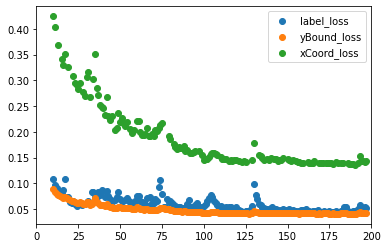

In [39]:
label_loss = history['label_loss']
yBound_loss = history['yBound_loss']
xCoord_loss = history['xCoord_loss']
index = range(len(label_loss))

plt.scatter(index[10:], label_loss[10:])
plt.scatter(index[10:], yBound_loss[10:])
plt.scatter(index[10:], xCoord_loss[10:])
plt.legend(["label_loss", "yBound_loss", "xCoord_loss"])
plt.xlim([0,200])

(0.0, 200.0)

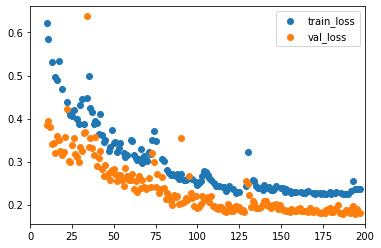

In [40]:
train_loss = history['train_loss']
val_loss = history['val_loss']
plt.scatter(index[10:], train_loss[10:])
plt.scatter(index[10:], val_loss[10:])
plt.legend(["train_loss", "val_loss"])
plt.xlim([0,200])

# Inference with validation data

In [80]:
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model.eval()
state_dict = torch.load("./models/1125_epoch188_evalLoss0.17832.pth")
model.load_state_dict(state_dict)

Using cache found in /Users/takeshikibayashi/.cache/torch/hub/facebookresearch_detr_master


<All keys matched successfully>

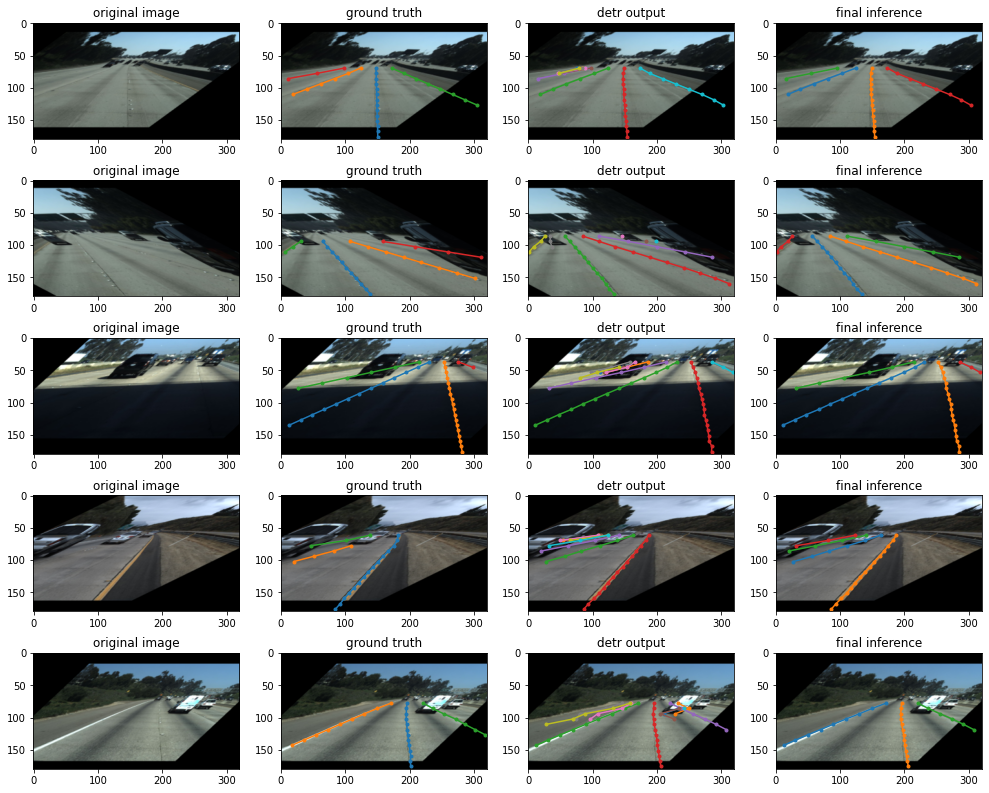

In [81]:
def drawInference(img, output):
    logit_thresh = 0.5
    
    img = np.array(img)
    output["pred_logits"] = output["pred_logits"].sigmoid()
    output = {k: v[0].detach().numpy() for k, v in output.items()}
    
    isLine = np.logical_and(output["pred_logits"][:,0]>output["pred_logits"][:,1],
                            output["pred_logits"][:,0]>logit_thresh)
    isLine = [0 if i==True else 1 for i in isLine]
    
    drawLine(img,
             labels=isLine,
             xListCoords=output["pred_xCoords"],
             yBoundaries=output["pred_yBounds"],
             yCoords=yCoords)

def drawAllInference(img, output):
    output["pred_logits"][:,:,0] = 100
    output["pred_logits"][:,:,1] = -100
    drawInference(img, output)

plt.figure(figsize=(17,14))
for i, r in enumerate(randint(0,len(val_dataset),5)):
    img, target = val_dataset[r]
    
    plt.subplot(5,4,4*i+1)
    plt.title("original image")
    plt.imshow(np.rollaxis(np.array(img),0,3))
    
    plt.subplot(5,4,4*i+2)
    plt.title("ground truth")
    drawLine(img, target["labels"], target["xCoords"], np.array(target["yBounds"]), yCoords)
    
    plt.subplot(5,4,4*i+4)
    plt.title("final inference")
    output = model(img[None])
    #output = model(torch.tensor(img[None]).to(device))
    drawInference(img, output)
    
    plt.subplot(5,4,4*i+3)
    plt.title("detr output")
    drawAllInference(img, output)

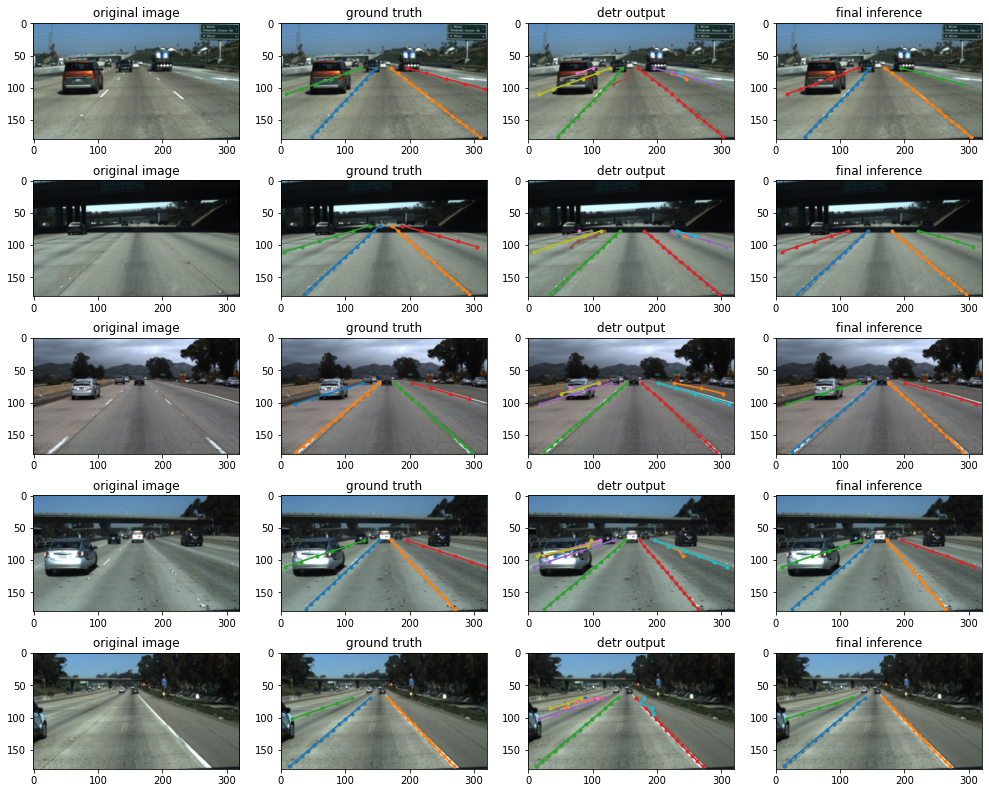

In [82]:
plt.figure(figsize=(17,14))
for i, r in enumerate(randint(0,len(val_dataset_noaug),5)):
    img, target = val_dataset_noaug[r]
    
    plt.subplot(5,4,4*i+1)
    plt.title("original image")
    plt.imshow(np.rollaxis(np.array(img),0,3))
    
    plt.subplot(5,4,4*i+2)
    plt.title("ground truth")
    drawLine(img, target["labels"], target["xCoords"], np.array(target["yBounds"]), yCoords)
    
    plt.subplot(5,4,4*i+4)
    plt.title("final inference")
    output = model(img[None])
    #output = model(torch.tensor(img[None]).to(device))
    drawInference(img, output)
    
    plt.subplot(5,4,4*i+3)
    plt.title("detr output")
    drawAllInference(img, output)